### 1. Analysis of the UniProt sequences

Analysis of UniProt sequences' compatibility with the proposed sequence scoring rules

In [6]:
import os
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import AlignIO
import pandas as pd
from script.sequence_scorer import create_mapping, score_seq

In [7]:
names = ["uniprot_sequence", "uniprot_sequence_250323"]

ref_sequence_ncbi_id = "AAB57849.1"
ref_sequence = "MAIPEEFDILVLGGGSSGSCIAGRLANLDHSLKVGLIEAGENNLNNPWVYLPGIYPRNMKLDSKTASFYTSNPSPHLNGRRAIVPCANVLGGGSSINFMMYTRGSASDYDDFQAEGWKTKDLLPLMKKTETYQRACNNPDIHGFEGPIKVSFGNYTYPVCQDFLRASESQGIPYVDDLEDLVTAHGAEHWLKWINRDTGRRSDSAHAFVHSTMRNHDNLYLICNTKVDKIIVEDGRAAAVRTVPSKPLNPKKPSHKIYRARKQIVLSCGTISSPLVLQRSGFGDPIKLRAAGVKPLVNLPGVGRNFQDHYCFFSPYRIKPQYESFDDFVRGDAEIQKRVFDQWYANGTGPLATNGIEAGVKIRPTPEELSQMDESFQEGYREYFEDKPDKPVMHYSIIAGFFGDHTKIPPGKYMTMFHFLEYPFSRGSIHITSPDPYAAPDFDPGFMNDERDMAPMVWAYKKSRETARRMDHFAGEVTSHHPLFPYSSEARALEMDLETSNAYGGPLNLSAGLAHGSWTQPLKKPTAKNEGHVTSNQVELHPDIEYDEEDDKAIENYIREHTETTWHCLGTCSIGPREGSKIVKWGGVLDHRSNVYGVKGLKVGDLSVCPDNVGCNTYTTALLIGEKTATLVGEDLGYSGEALDMTVPQFKLGTYEKTGLARF"

alphabet = ['-', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'X']
# X for what?
score_dict = {}
for resid, resnames, score in [
    (98, "FWY", 5), (417, "FWY", 2), (566, "FWY", 2),
    (567, "H", 5), (616, "HNP", 5),
    (13, "G", 5), (15, "G", 5), (18, "G", 5),
    (660, "-", -0.1), (661, "-", -0.1), (662, "-", -0.1), (663, "-", -0.1),
]:
    if not resid in score_dict.keys():
        score_dict[resid] = { resname:0 for resname in alphabet}
    for resname in resnames:
        score_dict[resid][resname] = score


In [34]:
def process_sequences(name):
    """
    Process sequences for a given name and return scores
    
    Args:
        name (str): Name used for file paths
        
    Returns:
        list: List of scores for the sequences
    """
    # Define file paths
    files = {
        "file": f"data/aox/raw/{name}.tsv",
        "fasta": f"data/aox/cache/uniprot_sequence/{name}.sequences.fasta",
        "msa": f"data/aox/cache/uniprot_sequence/{name}.alignment.fasta"
    }

    # Read data
    data = pd.read_csv(files['file'], sep='\t')
    
    sequences = []

    # Define length filtering parameters
    min_length, max_length = 0, 3000

    # Add reference sequence
    ref_record = SeqRecord(
        Seq(ref_sequence),
        id=ref_sequence_ncbi_id,
        description="reference sequence"
    )
    sequences.append(ref_record)

    # Count total sequences before filtering
    total_before_filter = len(data['Entry'])

    # Add sequences from data (with length filtering)
    for idx, (entry, seq) in enumerate(zip(data['Entry'], data['Sequence'])):
        if min_length <= len(seq) <= max_length:
            record = SeqRecord(
                Seq(seq),
                id=entry,
                description=f"sequence_{idx+1}"
            )
            sequences.append(record)

    # Write sequences to FASTA file
    with open(files['fasta'], 'w') as f:
        for record in sequences:
            f.write(f">{record.id}\n{str(record.seq)}\n")

    # Check if MSA file exists
    if not os.path.exists(files['msa']):
        raise FileNotFoundError(f"""The MSA file '{files['msa']}' does not exist
                                Run the MUSCLE software in the cmd console.
                                muscle.exe -align {files['fasta']} -output {files['fasta']}
                                """)

    # Read multiple sequence alignment
    alignment = AlignIO.read(files['msa'], "fasta")

    # Find reference sequence in alignment
    for record in alignment:
        if record.id == ref_sequence_ncbi_id:
            Reference_seq = record
            break

    # Create position mapping
    id2id_align = create_mapping(Reference_seq, first_id=1)

    # Score each sequence
    score_result = []
    for record in alignment:
        if record.id != ref_sequence_ncbi_id:
            seq = str(record.seq)
            score = score_seq(seq, score_dict, id2id_align)
            score_result.append((record.id, score))
    scores = [s for _, s in score_result]

    # Calculate statistics
    high_scores = sum([s >= 33.5 for s in scores])
    total_scores = len(scores)
    percentage = (high_scores / total_scores) * 100

    # Print results
    print(f"Total sequences before filtering: {total_before_filter}")
    print(f"Length filtering range: {min_length}-{max_length} bp")
    print(f"Reference sequence length: {len(ref_sequence)}")
    print(f"Number of filtered sequences: {len(sequences)-1}")  # -1 to exclude reference sequence
    print(f"Number of sequences with score ≥ 33.5: {high_scores}")
    print(f"Total number of sequences: {total_scores}")
    print(f"Percentage: {percentage:.2f}%")
    
    return scores


uniprot_sequence (231030 version)

In [36]:
name = names[0]
scores = process_sequences(name)

Total sequences before filtering: 104
Length filtering range: 0-3000 bp
Reference sequence length: 663
Number of filtered sequences: 104
Number of sequences with score ≥ 33.5: 35
Total number of sequences: 104
Percentage: 33.65%


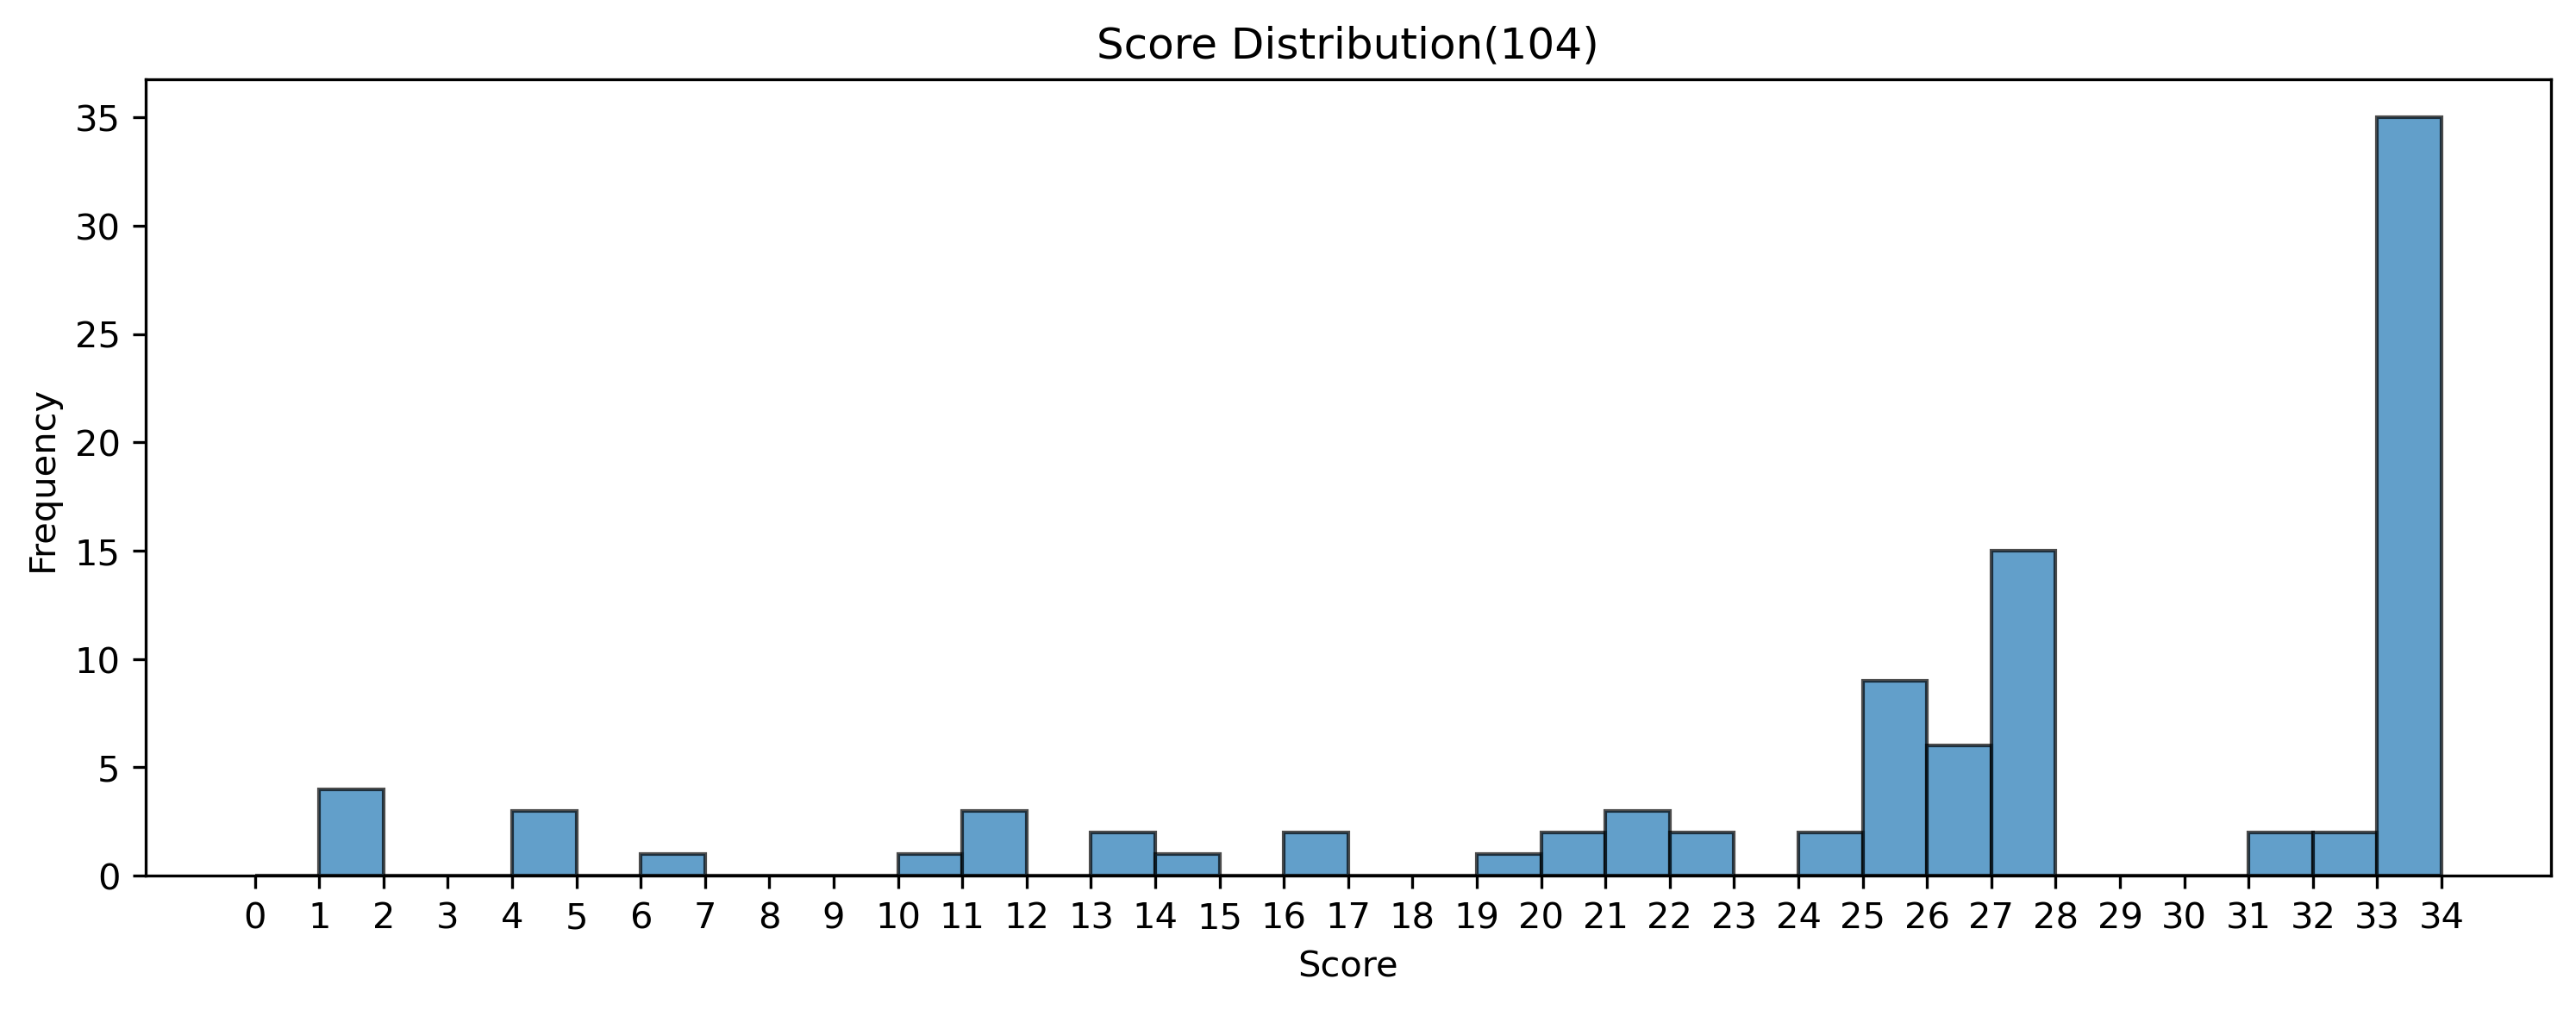

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Create bins from 0 to 34 with interval of 1
bins = np.arange(0, 35, 1)

# Plot histogram
plt.figure(figsize=(12, 4), dpi=300)
plt.hist(scores, 
         bins=bins,
         edgecolor='black',
         alpha=0.7)

# Set title and labels
plt.title(f'Score Distribution({len(scores)})')
plt.xlabel('Score')
plt.ylabel('Frequency')

# Set x-axis ticks
plt.xticks(bins)  # Show ticks for all bins

plt.show()


uniprot_sequence (250323 version)

In [29]:
name = names[1]
scores = process_sequences(name)

Total sequences before filtering: 135
Length filtering range: 0-3000 bp
Reference sequence length: 663
Number of filtered sequences: 135
Number of sequences with score ≥ 33.5: 57
Total number of sequences: 135
Percentage: 42.22%


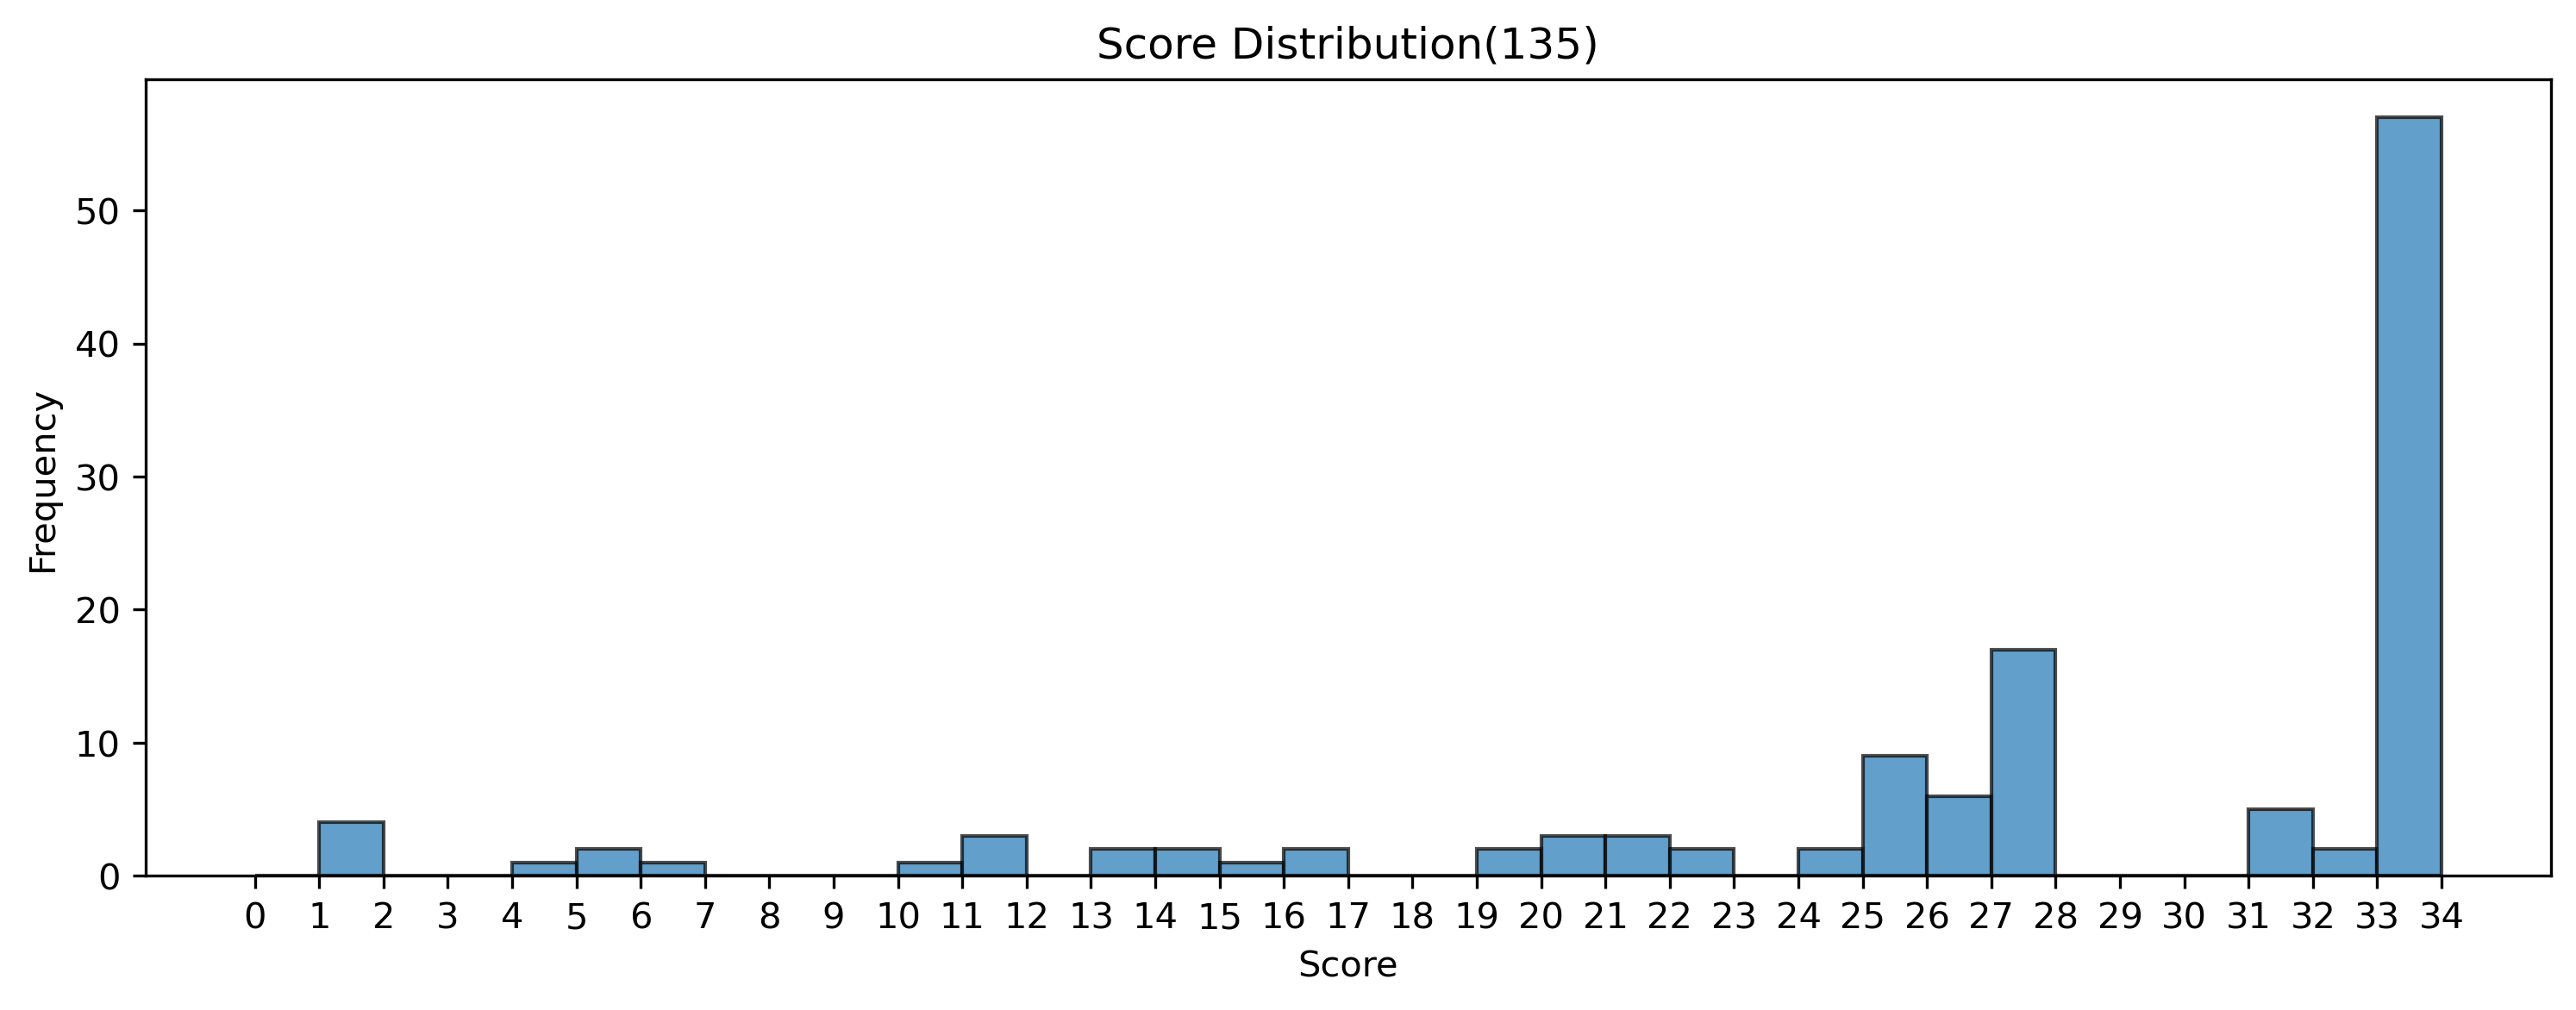

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Create bins from 0 to 34 with interval of 1
bins = np.arange(0, 35, 1)

# Plot histogram
plt.figure(figsize=(12, 4), dpi=300)
plt.hist(scores, 
         bins=bins,
         edgecolor='black',
         alpha=0.7)

# Set title and labels
plt.title(f'Score Distribution({len(scores)})')
plt.xlabel('Score')
plt.ylabel('Frequency')

# Set x-axis ticks
plt.xticks(bins)  # Show ticks for all bins

plt.show()


### 2. statistic analysis

Statistical analysis of the proportion of sequences with enhanced activity

In [48]:
import scipy.stats as stats

data = [
    [1, 2, 12], # control group
    [6, 18, 31] # work group
]

# 1. Analysis of highly active significance
contingency_table_1 = [
    [1, 12 - 1],
    [6, 31 - 6]
]
odds_ratio_1, p_value_1 = stats.fisher_exact(contingency_table_1)

# 2. Analysis of active significance
active_all = data[0][1]    # 2
active_all_2 = data[1][1]  # 18

contingency_table_2 = [
    [2, 12 - 2],
    [18, 31 - 18]
]
odds_ratio_2, p_value_2 = stats.fisher_exact(contingency_table_2)

print(f"Highly Active Analysis:")
print(f"Odds Ratio: {odds_ratio_1:.3f}")
print(f"P-value: {p_value_1:.3e}")
print("\nActive Analysis:")
print(f"Odds Ratio: {odds_ratio_2:.3f}")
print(f"P-value: {p_value_2:.3e}")


Highly Active Analysis:
Odds Ratio: 0.379
P-value: 6.520e-01

Active Analysis:
Odds Ratio: 0.144
P-value: 1.933e-02


### 3. analysis of the results

Analyze the reasons for the lack of activity in the samples, whether it was due to 

(1) misfolding leading to inclusion bodies, 

(2) aggregation after folding forming inclusion bodies, or 

(3) soluble expression without activity.

In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [91]:
data = pd.read_csv(r"data\aox\result\experiment_result.tsv", sep='\t')
data = data[data['round'] != 1]
data.head()

,#id,name,round,inclusion,activity(mU/mg),SD,Yield (mg/L),Main_Position
0,1,A0A0E0SDM0,3,0,4087.3,281.9,87.9,S
1,2,A0A1B7NGS0,3,0,0.0,0.0,53.1,"S,P"
2,3,A0A1Q3EBI7,3,1,0.0,0.0,0.0,P
3,4,A0A1X6MWH7,3,0,912.7,229.4,150.8,S
4,5,A0A2J6PTI5,3,1,0.0,0.0,0.0,P


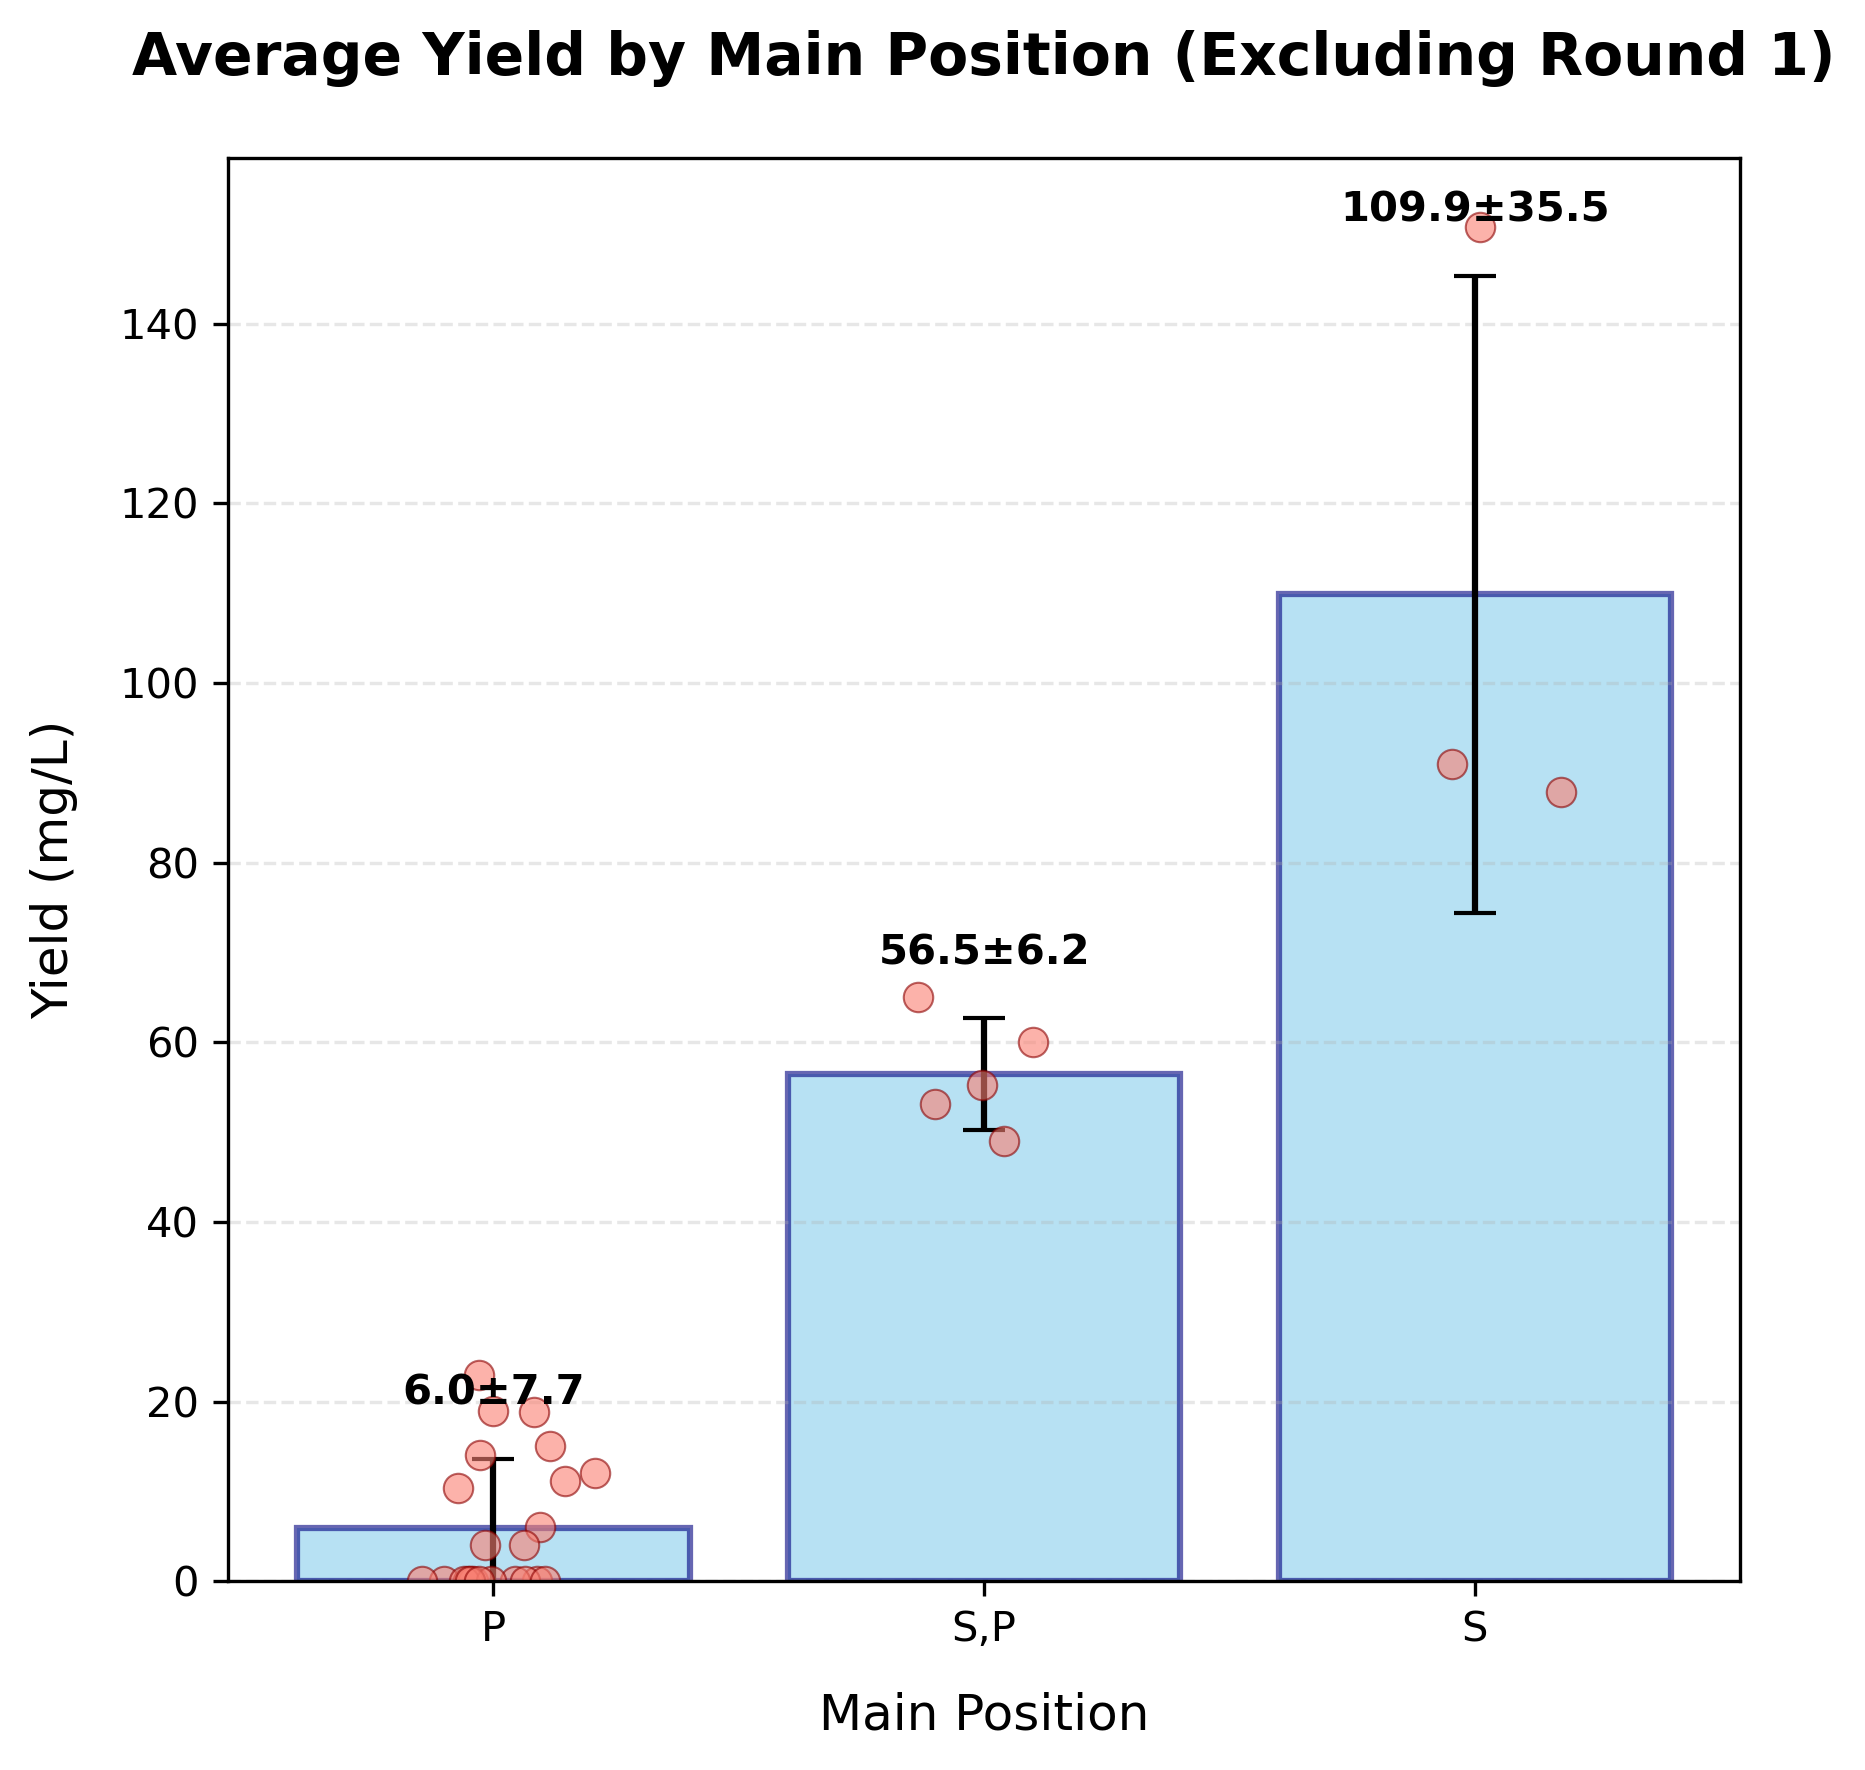

In [92]:
position_order = ['P', 'S,P', 'S']

yield_stats = data.groupby('Main_Position')['Yield (mg/L)'].agg(['mean', 'std'])
yield_stats = yield_stats.reindex(position_order)

plt.figure(figsize=(6, 6), dpi=300)

# Draw bar chart (with error bars)
bars = plt.bar(yield_stats.index, yield_stats['mean'], yerr=yield_stats['std'], 
               capsize=5, alpha=0.6, color='skyblue', 
               edgecolor='navy', linewidth=1.5)

# Add scatter points for each position
for idx, position in enumerate(position_order):
    position_data = data[data['Main_Position'] == position]['Yield (mg/L)']
    x_jitter = np.random.normal(loc=idx, scale=0.08, size=len(position_data))
    
    # Draw scatter points with edge effects
    plt.scatter(x_jitter, position_data, color='salmon', 
               alpha=0.6, zorder=2, s=50,
               edgecolor='darkred', linewidth=0.5)

plt.title('Average Yield by Main Position (Excluding Round 1)', pad=20, 
          fontsize=14, fontweight='bold')
plt.xlabel('Main Position', fontsize=12, labelpad=10)
plt.ylabel('Yield (mg/L)', fontsize=12, labelpad=10)

plt.grid(True, axis='y', linestyle='--', alpha=0.3)

plt.ylim(bottom=0)

plt.tick_params(axis='both', which='major', labelsize=10)
plt.xticks(range(len(yield_stats.index)), yield_stats.index, 
           rotation=0, ha='center')

# Add value labels
for i, (mean, std) in enumerate(zip(yield_stats['mean'], yield_stats['std'])):
    plt.text(i, mean + std + 5, f'{mean:.1f}±{std:.1f}', 
             ha='center', va='bottom',
             fontsize=10, fontweight='bold')

plt.box(True)

plt.tight_layout()

plt.show()


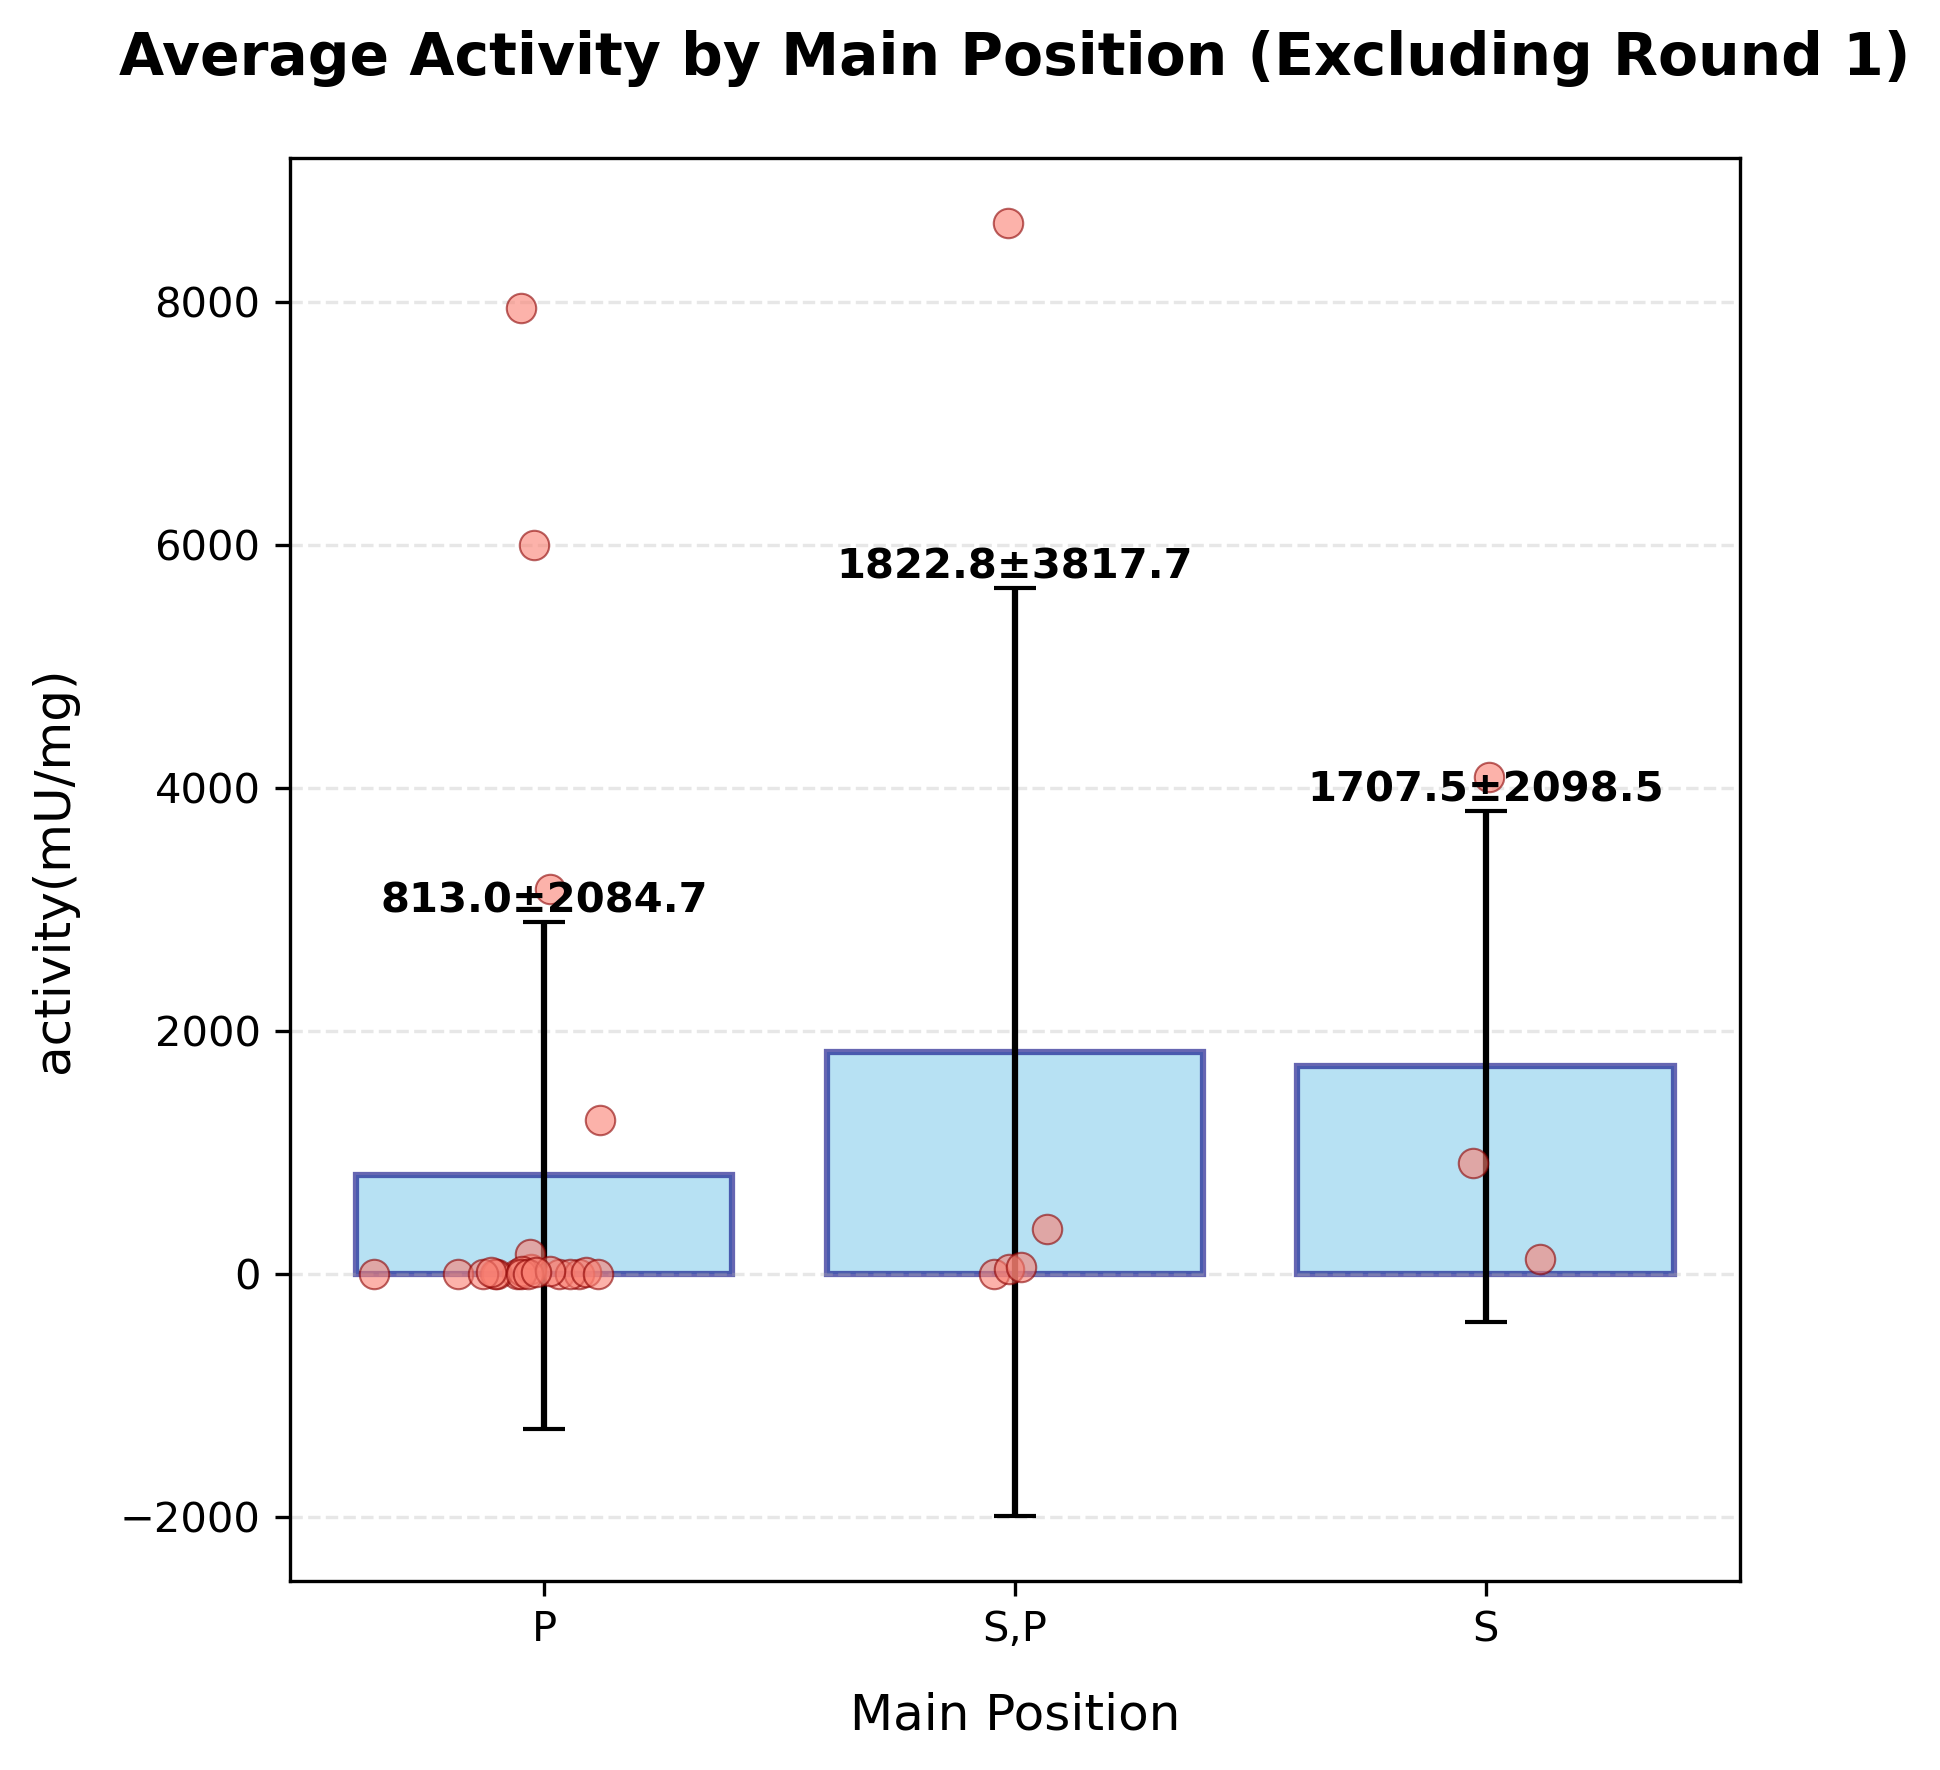

In [96]:
position_order = ['P', 'S,P', 'S']

activity_stats = data.groupby('Main_Position')['activity(mU/mg)'].agg(['mean', 'std'])
activity_stats = activity_stats.reindex(position_order)

plt.figure(figsize=(6, 6), dpi=300)

bars = plt.bar(activity_stats.index, activity_stats['mean'], yerr=activity_stats['std'], 
               capsize=5, alpha=0.6, color='skyblue', 
               edgecolor='navy', linewidth=1.5)

for idx, position in enumerate(position_order):
    position_data = data[data['Main_Position'] == position]['activity(mU/mg)']
    x_jitter = np.random.normal(loc=idx, scale=0.08, size=len(position_data))
    
    plt.scatter(x_jitter, position_data, color='salmon', 
               alpha=0.6, zorder=2, s=50,
               edgecolor='darkred', linewidth=0.5)

plt.title('Average Activity by Main Position (Excluding Round 1)', pad=20, 
          fontsize=14, fontweight='bold')
plt.xlabel('Main Position', fontsize=12, labelpad=10)
plt.ylabel('activity(mU/mg)', fontsize=12, labelpad=10)

plt.grid(True, axis='y', linestyle='--', alpha=0.3)

# plt.ylim(bottom=0)

plt.tick_params(axis='both', which='major', labelsize=10)
plt.xticks(range(len(activity_stats.index)), activity_stats.index, 
           rotation=0, ha='center')

for i, (mean, std) in enumerate(zip(activity_stats['mean'], activity_stats['std'])):
    plt.text(i, mean + std + 5, f'{mean:.1f}±{std:.1f}', 
             ha='center', va='bottom',
             fontsize=10, fontweight='bold')

plt.box(True)

plt.tight_layout()

plt.show()


In [94]:
sorted_data = data.sort_values(by='activity(mU/mg)', ascending=False)

sorted_data

,#id,name,round,inclusion,activity(mU/mg),SD,Yield (mg/L),Main_Position
7,8,A0A4U6X6L6,3,0,8647.0,294.9,55.3,"S,P"
6,7,A0A423XHQ7,3,0,7946.0,697.5,18.8,P
11,12,A0A5N5JXS7,3,0,5997.7,79.4,10.4,P
0,1,A0A0E0SDM0,3,0,4087.3,281.9,87.9,S
8,9,A0A4Z1KC62,3,0,3170.8,738.2,11.1,P
9,10,A0A5B1QN96,3,0,1269.8,423.5,4.0,P
3,4,A0A1X6MWH7,3,0,912.7,229.4,150.8,S
28,29,A0A0D2AFJ7,2,0,369.6,34.5,49.0,"S,P"
14,15,F8Q303,2,0,166.7,9.6,6.0,P
30,31,CDG66232.1,2,0,122.6,6.3,91.0,S


In [100]:
data['highly_active'] = data['activity(mU/mg)'] > 1000

grouped_stats = data.groupby(['Main_Position', 'highly_active']).agg({
    'activity(mU/mg)': ['count', 'mean', 'std'],
    'highly_active': 'size'
}).round(2)

position_percentages = data.groupby('Main_Position').agg({
    'highly_active': [
        ('total', 'count'),
        ('highly_active_count', 'sum'),
        ('percentage', lambda x: (sum(x) / len(x) * 100))
    ]
}).round(2)

print("\n=== Detailed Group Statistics ===")
print(grouped_stats)
print("\n=== Highly Active Percentage by Position ===") 
print(position_percentages)


=== Detailed Group Statistics ===
                            activity(mU/mg)                   highly_active
                                      count     mean      std          size
Main_Position highly_active                                                
P             False                      19    16.51    38.39            19
              True                        4  4596.08  2959.85             4
S             False                       2   517.65   558.69             2
              True                        1  4087.30      NaN             1
S,P           False                       4   116.78   170.28             4
              True                        1  8647.00      NaN             1

=== Highly Active Percentage by Position ===
              highly_active                               
                      total highly_active_count percentage
Main_Position                                             
P                        23                   4      17.39